# Monte carlo simulation

In [1]:
import numpy as np 
import polars as pl 
from polars import col 
import matplotlib.pyplot as plt 
import seaborn as sb 

%load_ext autoreload
%autoreload 2
plt.style.use("../matplotlibrc")

In [2]:
from findec.returns import draw_lognormal_return
from findec.utility import composite_crra_utility
from findec.dataclasses import Preferences

In [3]:
preferences = Preferences()

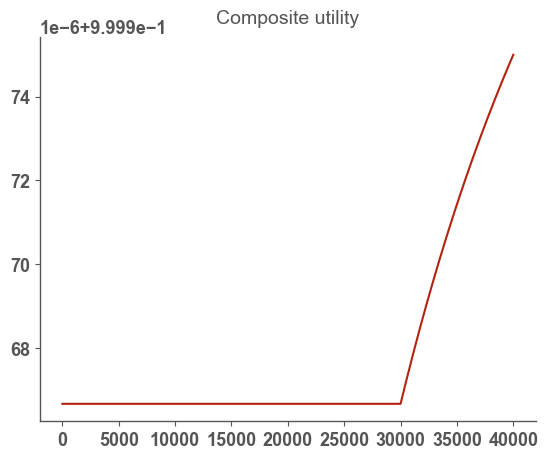

In [4]:
w = np.linspace(0, 40e3, 1000)
u = np.array([composite_crra_utility(wi, pref=preferences) for wi in w])
fig, ax = plt.subplots()
ax.plot(w, u)
ax.set_title("Composite utility");

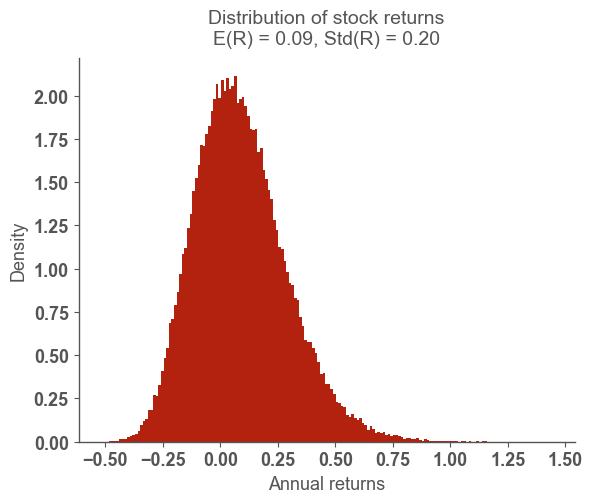

In [5]:
stock_returns = draw_lognormal_return(n_sims=100_000)
fig, ax = plt.subplots()
ax.hist(stock_returns, bins="auto", density=True)
stock_returns_mean = stock_returns.mean()
stock_returns_std = stock_returns.std()
ax.set_xlabel("Annual returns")
ax.set_ylabel("Density")
ax.set_title(
    f"Distribution of stock returns\nE(R) = {stock_returns_mean:.2f}, Std(R) = {stock_returns_std:.2f}"
);

In [24]:
from findec.dataclasses import Assets

a = Assets(tax_free=600, taxable=400)
a.total_wealth

1000

In [25]:
a

Assets(tax_free=600, taxable=400)

In [26]:
consumed = a.consume(500)

In [27]:
consumed

500

In [28]:
a

Assets(tax_free=500, taxable=0)

In [29]:
a.total_wealth

500

In [ ]:
from findec.utility import wealth_to_gamma, bequest_utility
from findec.policy import merton_share, policy
from findec.dataclasses import Preferences, Assets, RiskyAsset
from findec.returns import risk_adjusted_excess_return
from findec.survival import (
    age_to_death_probability_female,
    age_to_death_probability_male,
)

expected_return_risky = 0.09
std_dev_return_risky = 0.20
risk_free_rate = 0.04

initial_assets = Assets(tax_free=400_000.0, taxable=600_000.0)


def simulate_life_path(
    *,
    expected_return_risky: float,
    std_dev_return_risky: float,
    risk_free_rate: float,
    p: Preferences,
    a: Assets,
    ra: RiskyAsset,
    social_security: float,
    time_horizon: int,
    rng_seed=None,
    starting_age: int = 65,
    is_male: bool = False,
):
    if rng_seed is not None:
        np.random.seed(rng_seed)
    if is_male:
        age_to_death_probability = age_to_death_probability_male
    else:
        age_to_death_probability = age_to_death_probability_female

    expected_excess_return = expected_return_risky - risk_free_rate

    total_utility = 0.0
    alive = True

    for t in range(1, time_horizon + 1):
        age = starting_age + t
        wealth = a.tax_free + a.taxable
        gamma = wealth_to_gamma(
            wealth,
            subsistence=p.subsistence,
            gamma_below_subsistence=p.gamma_below_subsistence,
            gamma_above_subsistence=p.gamma_above_subsistence,
        )

        if np.random.rand() < age_to_death_probability[age]:
            alive = False
            bu = bequest_utility(wealth, b=p.bequest_param, gamma=gamma)
            total_utility += bu

        p = policy(
            time_horizon=time_horizon,
            gamma=gamma,
            pref=p,
            risk_free_rate=risk_free_rate,
            risky_asset=ra,
        )

        a.taxable += social_security

        risk_adjusted_excess_return(
            expected_excess_return, std_dev_return=std_dev_return_risky, gamma=gamma
        )